# Notebook to make figures on Sentinel-1 NRB sample product

Comparison of Sentinel-1 RTC output for an area in Western Austria, with steep terrain and forest cover. 

Method used to produce the RTC and per-pixel metadata:
1. (option 1) Normalize to gamma0_rtc in GRD pixels for all pixels; for each output pixel, interpolate gamma0_rtc and scattering area image. Shadow mask in GRD is extended by 1 pixel using a MAX filter then interpolated with nearest neightbor resampling to output pixel.

The optimal RTC output should have:
1. Minimal artifacts near radar shadow. Inside and near the radar shadow, scattering area is either zero or a small value, so a small uncertainty in the scattering area leads to large uncertainty in gamma0_rtc. Any pixel that is potentially affected by this uncertainty should be masked out.
2. Consistent backscatter measured between ascending and descending passes. The images used in the comparison are taken one day apart, therefore no signifant land cover change is expected between the two passes.
3. For areas with uniform forest cover, gamma0_rtc should have minimal dependence on look angle.


In [1]:
%matplotlib inline

import warnings
warnings.simplefilter('ignore')
import glob
import json
import os

import datacube
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

#import DE Africa script
#import sys
#sys.path.append('../Scripts')
#from deafrica_plotting import display_map

In [2]:
!ls ~/dev/s1_sample_austria/

test_Austria_Ascending_Bilinear_COPDEM30_Option1_MAX1NN_2020-07-07
test_Austria_Ascending_Bilinear_COPDEM30_Option1_MAX1NN_2020-07-07.zip
test_Austria_Descending_Bilinear_COPDEM30_Option1_MAX1NN_2020-07-06
test_Austria_Descending_Bilinear_COPDEM30_Option1_MAX1NN_2020-07-06.zip


### Load S1 sample data

In [3]:
def load_s1_sample(s1_sample_path, band, time=None):
    fname = glob.glob(f"{s1_sample_path}/*{band}.tif")[0]
    if time:
        return xr.open_rasterio(fname, chunks={"x": 1000, "y": 1000}).squeeze().to_dataset(name=band).expand_dims({'time':[time]})
    else:
        return xr.open_rasterio(fname, chunks={"x": 1000, "y": 1000}).squeeze().to_dataset(name=band)

In [4]:
# figure for a different area

In [5]:
#dc=datacube.Datacube()
#dem = dc.load(product='srtm', lat=lat, lon=lon).squeeze()
#dem.elevation.plot.imshow(robust=True);

In [6]:
# load data from option 1

bands = ["VV", "VH", "MASK", "AREA", "ANGLE"]
s1_sample_path = "/home/jovyan/dev/s1_sample_austria/test_Austria_Descending_Bilinear_COPDEM30_Option1_MAX1NN_2020-07-06"
data = [load_s1_sample(s1_sample_path, band, time=np.datetime64('2020-07-06')) for band in bands]
s1_sample_path = "/home/jovyan/dev/s1_sample_austria/test_Austria_Ascending_Bilinear_COPDEM30_Option1_MAX1NN_2020-07-07"
data += [load_s1_sample(s1_sample_path, band, time=np.datetime64('2020-07-07')) for band in bands]

combined_1 = xr.merge(data)

In [9]:
# select area with terrain

lat, lon = (46.65,46.6),  (12.35,12.40) # steep but some rocky top

lat, lon = (46.3,46.2), (12.32,12.42) # steep, mostly forest cover

#lat, lon = (46.36,46.26), (12.82,12.92) # slightly flatter, mostly forest cover

#lat, lon = (46.26,46.16), (12.0,12.1) # steep, forest cover

y=slice(*lat)
x=slice(*lon)

combined_sub_1 = combined_1.sel(y=y, x=x).drop('band').compute()
combined_sub_1["VV_db"] = 10 * np.log10(combined_sub_1["VV"])
combined_sub_1["VH_db"] = 10 * np.log10(combined_sub_1["VH"])

In [10]:
# check area in map

#display_map(x=lon, y=lat)
#display_map(x=(12, 13), y=(47, 46))

In [11]:
from datacube.utils.geometry import GeoBox, box, CRS
import rioxarray
from odc.algo import xr_reproject

def load_from_cog(url, name=None, resampling = 'nearest', chunks = dict(x=10_000, y=10_000), **kwargs):
    output_grid = kwargs.get('geobox')
    if output_grid is None:
        try:
            x = kwargs['x']
            y = kwargs['y']
            resolution = kwargs['resolution']
            output_crs = kwargs['output_crs']
            input_crs = kwargs.get('crs', 'EPSG:4326')
        except KeyError:
            print("x, y, resolution and output_crs are required if geobox is not supplied.")
            return
        # define output geometry
        gbox = box(x[0], y[0], x[1], y[1], crs = input_crs)
        # define output bounding box
        output_gbox = gbox.to_crs(crs=CRS(output_crs))
        # define output grid
        output_grid = GeoBox.from_geopolygon(output_gbox, resolution = resolution)

    img_all = rioxarray.open_rasterio(url, chunks=chunks).squeeze('band')
    if name is None: name = url.split('/')[-1].split('.')[0]
    img_all.name = name 
    return xr_reproject(img_all, output_grid, resampling=resampling).compute()

#url = 'https://deafrica-data.s3-us-west-2.amazonaws.com/ancillary/dem-derivatives/cog_slope_africa.tif'


In [12]:
# vegetation index
#veg_1 = 4 * combined_sub_1.VH / (combined_sub_1.VH + combined_sub_1.VV)

In [13]:
# super rough forest area estimate
#forest_1 = (veg_1 > 0.8) & (combined_sub_1.VV_db > -15) #& (srtm.elevation.values>800)

In [14]:
#forest_1.isel(time=0).plot.imshow(robust=True, figsize=(12,10));

## Figures for paper

In [15]:
dpi = 120
plt.rc('font', size=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [16]:
for band in ['VV', 'VH', 'VV_db', 'VH_db']:
    combined_sub_1[band] = combined_sub_1[band].where(combined_sub_1.MASK==1)

In [17]:
combined_sub_1.quantile([0.02,0.98]).values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:   (quantile: 2)
Coordinates:
  * quantile  (quantile) float64 0.02 0.98
Data variables:
    VV        (quantile) float64 0.02115 0.6297
    VH        (quantile) float64 0.005714 0.1403
    MASK      (quantile) float64 1.0 2.0
    AREA      (quantile) float64 0.0 21.34
    ANGLE     (quantile) float64 7.0 94.0
    VV_db     (quantile) float64 -16.75 -2.008
    VH_db     (quantile) float64 -22.43 -8.529>

In [18]:
    
for band, title, vrange in zip(['ANGLE','AREA','VV', 'VH','VV_db', 'VH_db'], 
                                ['Local Incidence Angle (deg)', 'Scattering Area (unitless)', 'VV', 'VH', 'VV (dB)', 'VH (dB)'], 
                                [[10,90], None, [0.,0.6], [0.0, 0.14], [-16., -2], [-22, -8]]):

    break
    for itime, orbit in zip([0,1], ['d', 'a']):

        fig=plt.figure(dpi=dpi)
        ax = fig.add_subplot(111)
        if 'VV' in band or 'VH' in band:
            da = combined_sub_1.isel(time=itime)[band].where(combined_sub_1.isel(time=itime).MASK==1)
        else:
            da = combined_sub_1.isel(time=itime)[band]
        if vrange:
            da.rename(title).rename({'x':'Longitude','y':'Latitude'}).plot.imshow(vmin=vrange[0], vmax=vrange[1])
        else:
            da.rename(title).rename({'x':'Longitude','y':'Latitude'}).plot.imshow(robust=True)
        ax.set_aspect('equal')
        plt.savefig("%s_%s.eps"%(band.lower(), orbit), bbox_inches='tight');

In [47]:
### Loal Resolution Weighting
weight_1 = 1/combined_sub_1.AREA.where(combined_sub_1.MASK==1)
combined_sub_1_vv = (combined_sub_1.VV.where(combined_sub_1.MASK==1)*weight_1).sum('time')/weight_1.sum('time')

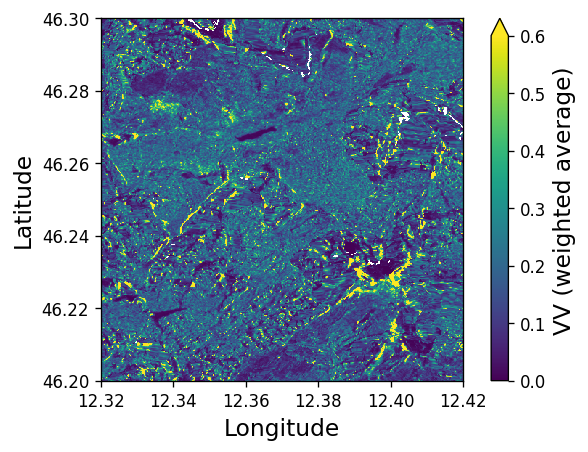

In [50]:
fig=plt.figure(dpi=dpi)
ax = fig.add_subplot(111)
combined_sub_1_vv.rename('VV (weighted average)').rename({'x':'Longitude','y':'Latitude'}).plot.imshow(vmin=0, vmax=0.6)
ax.set_aspect('equal')
plt.savefig("LRW_VV.eps", bbox_inches='tight');

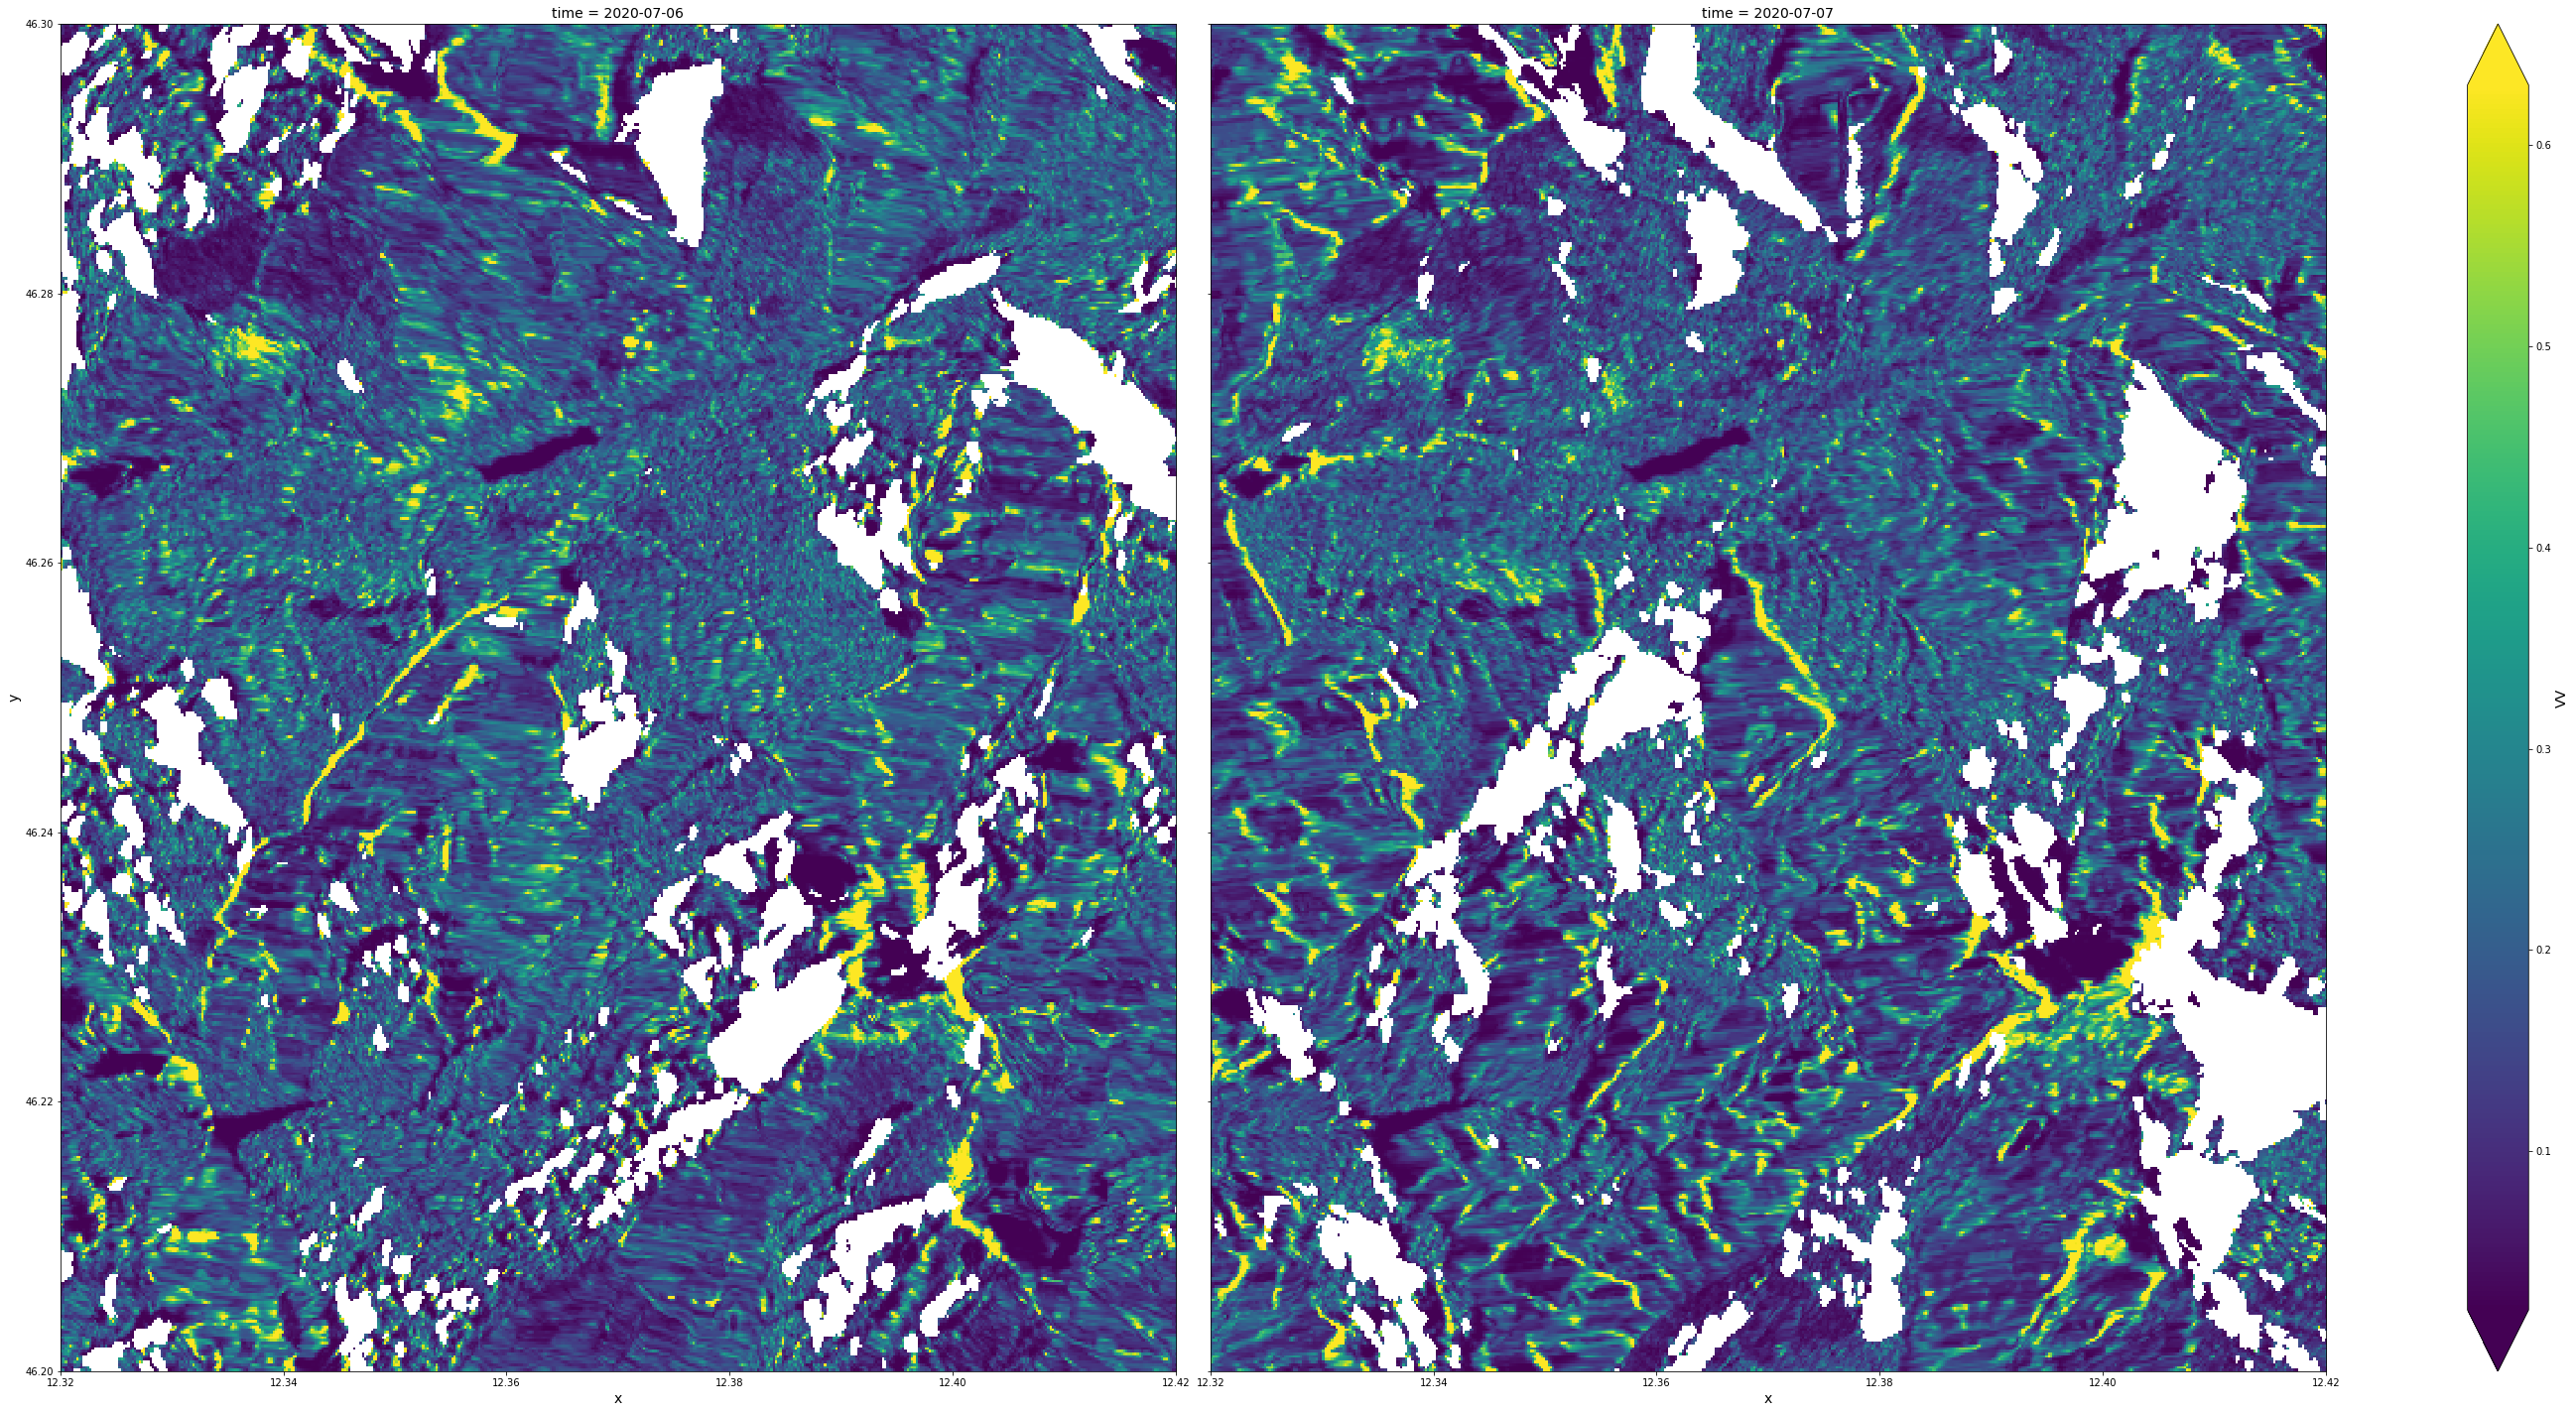

In [49]:
combined_sub_1.VV.plot.imshow(col='time',robust=True, size=20);